In [ ]:
!pip install pillow

In [ ]:
!pip install --upgrade scikit-learn 

In [ ]:
!pip install --upgrade keras

In [ ]:
!pip install torch==1.0

In [ ]:
!pip install torchvision==0.4.1

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import torch
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F

In [ ]:
import torchvision
from torchvision import datasets, transforms, models

In [ ]:
from PIL import Image

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/My Drive/datasets csv/Data'

In [ ]:


# Function to read the data; crop and resize the images; and then split it into test and train chunks.
def load_split_train_test(datadir, valid_size = .2):
    # This line of code transforms the images.
    train_transforms = transforms.Compose([
                                       transforms.RandomResizedCrop(224),
                                       transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])

    test_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                          transforms.Resize(224),
                                          transforms.ToTensor(),
                                      ])

    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)
    return trainloader, testloader

# We're using 20% of data for testing.
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['Basalt', 'Highland']


In [ ]:
# Transform the new image into numbers and resize it.
test_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.Resize(224),
                                      transforms.ToTensor(),
                                    ])

# A function to randomly select a set of images.
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

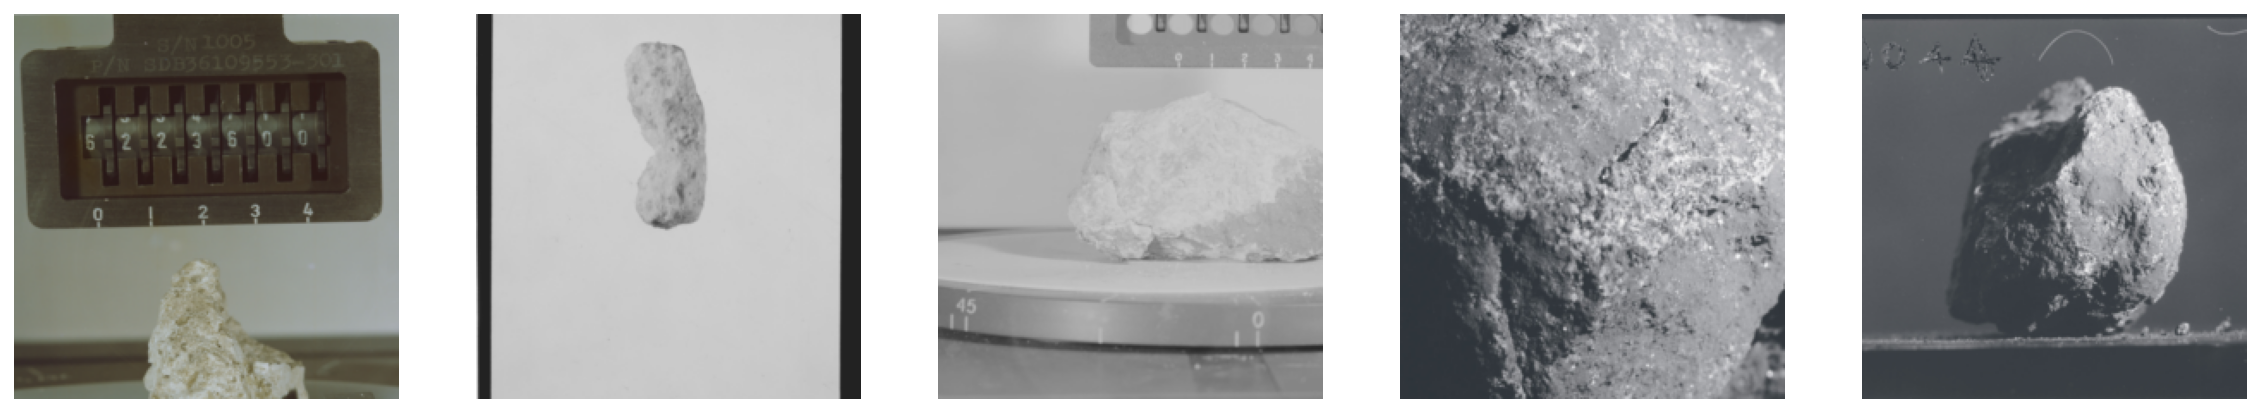

In [ ]:
# How many images do you want to see? It's set to 5, but you can change the number.
images, labels = get_random_images(5)
to_pil = transforms.ToPILImage()
fig=plt.figure(figsize=(20,20))
classes=trainloader.dataset.classes
for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [ ]:
# Determine whether you're using a CPU or a GPU to build the deep learning network.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 228MB/s]


In [ ]:
# Builds all the neurons.
for param in model.parameters():
    param.requires_grad = False

# The parameters of our deep learning model.
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 2),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)
print('done')

done


In [ ]:
#Entrenamiento
epochs = 5
steps = 0
running_loss = 0
print_every = 5
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:

        steps += 1
        print('Training step ', steps)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Training step  1
Training step  2
Training step  3
Training step  4
Training step  5
Epoch 1/5.. Train loss: 1.596.. Test loss: 0.564.. Test accuracy: 0.615
Training step  6
Training step  7
Training step  8
Training step  9
Training step  10
Epoch 2/5.. Train loss: 0.422.. Test loss: 0.415.. Test accuracy: 0.771
Training step  11
Training step  12
Training step  13
Training step  14
Training step  15
Epoch 2/5.. Train loss: 0.345.. Test loss: 0.337.. Test accuracy: 0.871
Training step  16
Training step  17
Training step  18
Training step  19
Training step  20
Epoch 3/5.. Train loss: 0.284.. Test loss: 0.647.. Test accuracy: 0.650
Training step  21
Training step  22
Training step  23
Training step  24
Training step  25
Epoch 4/5.. Train loss: 0.372.. Test loss: 0.197.. Test accuracy: 0.935
Training step  26
Training step  27
Training step  28
Training step  29
Training step  30
Epoch 4/5.. Train loss: 0.244.. Test loss: 0.236.. Test accuracy: 0.838
Training step  31
Training step  32
T

In [ ]:
print(accuracy/len(testloader))

0.9041666686534882


In [ ]:
#guardamos el modelo
torch.save(model, 'aerialmodel.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist

In [ ]:
#El código siguiente carga la red neuronal:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('aerialmodel.pth')

In [ ]:
#Este código crea una función que predice el tipo de la imagen nueva:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
#Vamos a elegir cinco imágenes aleatorias 
images, labels = get_random_images(5)

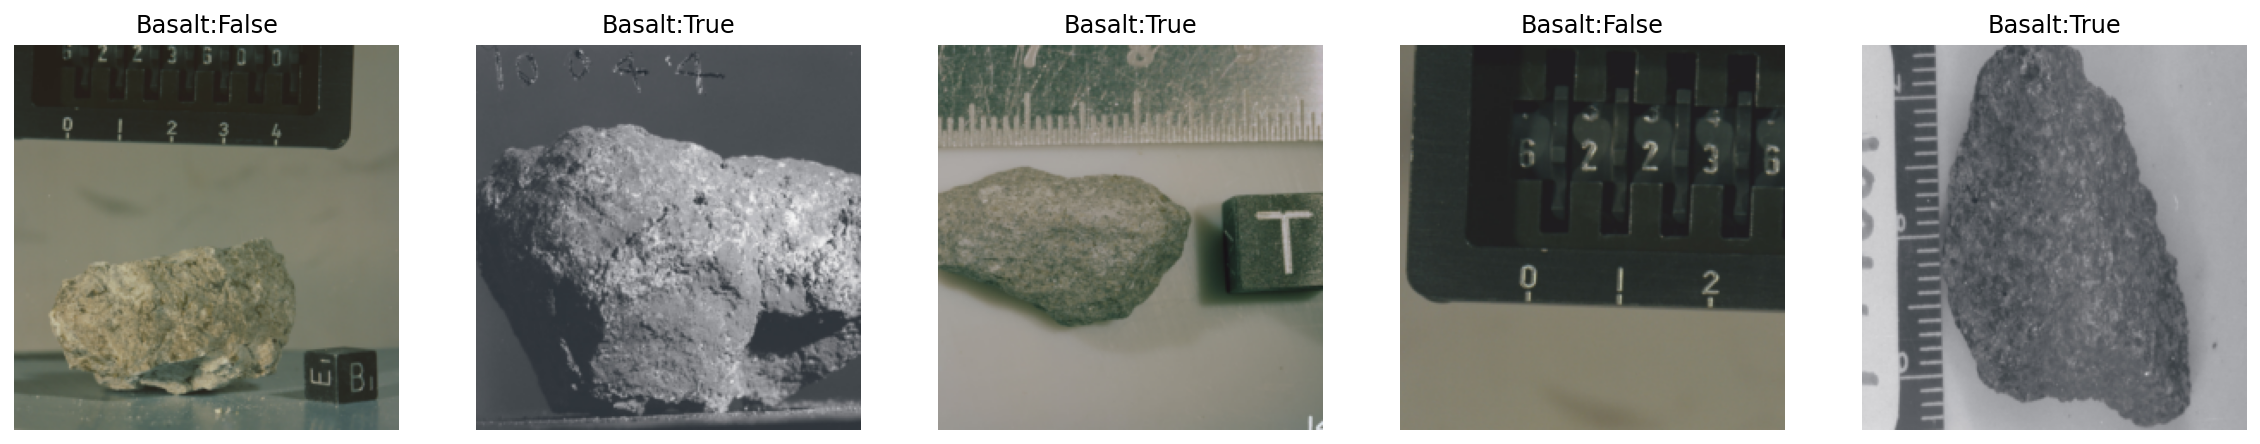

In [ ]:
#Este código visualiza las imágenes nuevas y agrega leyendas que indican qué tipo de roca contiene la foto según el modelo.

to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(20,10))

classes=trainloader.dataset.classes
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()